# 使用Char RNN对姓名进行分类
我们下面会训练一个字符级别的RNN模型来预测一个姓名是哪个国家人的姓名。我们的数据集收集了18个国家的近千个人名(英文名，注意中国人也是英文名，否则就是语言识别问题了），我们最终的模型就可以预测这个姓名是哪个国家的人：

$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch

## 准备数据
在data/names目录下有18个文本文件，命名规范为[语言].txt。每个文件的每一行都是一个人名。此外，我们实现了一个unicode_to_ascii把诸如à之类转换成a。

最终我们得到一个字典category_lines， {language: [names ...]}。key是语言名，value是名字的列表。all_letters里保存所有的字符。

In [36]:
import glob

all_filenames = glob.glob('../data/names/*.txt')
print(all_filenames)

['../data/names/Portuguese.txt', '../data/names/Korean.txt', '../data/names/Greek.txt', '../data/names/English.txt', '../data/names/Italian.txt', '../data/names/Dutch.txt', '../data/names/Irish.txt', '../data/names/Spanish.txt', '../data/names/Vietnamese.txt', '../data/names/Chinese.txt', '../data/names/Arabic.txt', '../data/names/German.txt', '../data/names/Japanese.txt', '../data/names/Scottish.txt', '../data/names/French.txt', '../data/names/Russian.txt', '../data/names/Czech.txt', '../data/names/Polish.txt']


In [37]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [38]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [39]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 把姓名(String)变成Tensor

现在我们已经把数据处理好了，接下来需要把姓名从字符串变成Tensor，因为机器学习只能处理数字。

为了表示一个字母，我们使用“one-hot"的表示方法。这是一个长度为<1 x n_letters>的向量，对应字符的下标为1，其余为0。

对于一个姓名，我们用大小为<line_length x 1 x n_letters>的Tensor来表示。第二维表示batch大小，因为PyTorch的RNN要求输入是< time x batch x input_features>。

In [40]:
import torch

# 把一个字母变成<1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

#  把一行(名字)转换成<line_length x 1 x n_letters>的Tensor
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [41]:
print(letter_to_tensor('A'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


## 创建网络
如果想“手动”创建，那么在PyTorch里创建RNN和全连接网络的代码并没有太大差别。因为PyTorch的计算图是动态实时编译的，不同time-step的for循环不需要“内嵌”在RNN里。因此每个训练数据即使长度不同也没有关系，因为每次都是根据当前的数据长度“实时”编译出来的计算图。
网络结构如下图所示：

![](network.png)



In [42]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## 手动测试网络

In [43]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

为了运行网络的一个step，我们需要传入当前时刻的输入(在这里是一个字母)和前一个隐状态。运行一次之后我们可以得到输出和下一个隐状态。

注意PyTorch模块需要变量而不是Tensor。

In [44]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


为了高效，我们不会每一个step都创建一个Tensor，因此我们使用line_to_tensor并且使用切片来选择一个字符。更进一步的优化可以使用batch的Tensor。

In [45]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8509, -2.8969, -2.8901, -2.8594, -2.8999, -2.8880, -2.8469,
         -2.9089, -2.8506, -2.9297, -2.9212, -2.8451, -2.9812, -2.9390,
         -2.8964, -2.8685, -2.8348, -2.9327]])


我可以看出，输出是一个<1 x n_categories> 的Tensor，表示输出每个category的概率。

## 准备训练

训练之前，我们需要一些工具函数。第一个就是根据网络的输出把它变成分类，我们这里使用Tensor.topk来选取概率最大的那个下标，然后得到分类名称。：

In [46]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

('Czech', 16)


我们也需要一个函数来随机挑选一个训练数据：

In [47]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Italian / line = Pesaresi
category = Dutch / line = Nifterik
category = Polish / line = Kozlow
category = Arabic / line = Atiyeh
category = English / line = Thatcher
category = Korean / line = Woo
category = Czech / line = Prachar
category = Greek / line = Close
category = Japanese / line = Inouye
category = German / line = Cline


## 训练网络

现在我们可以训练网络了，因为RNN的输出已经取过log了，所以计算交叉熵只需要选择正确的分类对于的值就可以了，PyTorch提高了nn.NLLLoss()函数来实现这个目的，它基本就是实现了loss(x, class) = -x[class]。

In [48]:
criterion = nn.NLLLoss()

我们用optimizer而不是自己手动来更新参数，这里我们使用最原始的SGD算法。

In [49]:
learning_rate = 0.005 
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [50]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

接下来我们就要用训练数据来训练了。因为上面的函数同时返回输出和损失，我们可以保存下来用于绘图。

In [51]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # 随机选择一个样本
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.7199 Markytan / Irish ✗ (Czech)
10000 10% (0m 8s) 1.9880 Pereira / Italian ✗ (Portuguese)
15000 15% (0m 12s) 1.3121 Si / Korean ✓
20000 20% (0m 17s) 1.2234 Maceachthighearna / Irish ✓
25000 25% (0m 21s) 1.2451 Torres / Portuguese ✓
30000 30% (0m 26s) 2.5215 Guillory / English ✗ (French)
35000 35% (0m 30s) 1.9661 Ton / Korean ✗ (Vietnamese)
40000 40% (0m 34s) 1.1618 Zhurkin / Russian ✓
45000 45% (0m 39s) 1.6795 Mendelssohn / Dutch ✗ (German)
50000 50% (0m 44s) 0.0529 Antimisiaris / Greek ✓
55000 55% (0m 49s) 4.4218 Oorschot / Scottish ✗ (Dutch)
60000 60% (0m 53s) 0.4951 Jue / Chinese ✓
65000 65% (0m 58s) 1.2338 Atiyeh / Arabic ✓
70000 70% (1m 2s) 3.2467 Petersen / Dutch ✗ (Czech)
75000 75% (1m 7s) 2.1980 Roles / Portuguese ✗ (English)
80000 80% (1m 11s) 0.2940 Parent / French ✓
85000 85% (1m 15s) 0.4599 Gomatos / Greek ✓
90000 90% (1m 19s) 0.5917 Tze / Chinese ✓
95000 95% (1m 23s) 1.5835 Matos / Greek ✗ (Portuguese)
100000 100% (1m 28s) 0.7840 Oorschot / Dutch ✓


## 结果绘图

把所有的损失都绘制出来可以显示学习的效果。

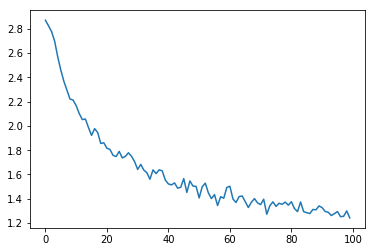

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## 评估效果

为了查看模型的效果，我们需要创建一个混淆矩阵，每一行代表样本实际的类别，而每一列表示模型预测的类别。为了计算混淆矩阵，我们需要使用evaluate方法来预测，它和train()基本一样，只是少了反向计算梯度的过程。

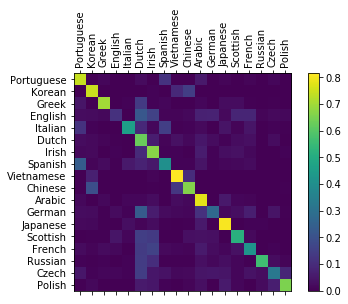

In [53]:
# 混淆矩阵
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# 最好是有一个测试数据集，我们这里随机从训练数据里采样
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 归一化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置x轴的文字往上走
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

演示越深值越大，因此可以看出中国人名最容易和韩国人混淆。

## 测试

我们首先实现predict函数，它会预测输入名字概率最大的3个国家。然后手动输入几个训练数据里不存在的人名试一试

In [54]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.88) Russian
(-1.25) Czech
(-2.29) Polish

> Jackson
(-0.70) Scottish
(-1.32) English
(-2.09) Russian

> Satoshi
(-0.87) Japanese
(-1.57) Arabic
(-1.99) Italian
